Mills College

CS 141-241, Machine Learning Fall 2018

Instructor: Jahan Ghofraniha

Final Project

Due date: 12/18/2018

Ian de Heer and Juliana de Heer

<h1>Instacart Project</h1>

<h3>Executive Summary</h3>
.
.
.

<h3>Introduction/Background</h3>

The Instacart Market Basket Analysis competition was released on Kaggle.com in May of 2017 and challenged the Kaggle community to use anonymized data from over 3 million orders to predict what would be in a given users cart the next time they placed an order. Over 2,600 people entered the competition and submitted nearly 40,000 entries before the competition closed in August of that year. While we are no longer able to participate in that challenge, we have taken it upon ourselves to come up with our own solution and see how close we can come to the best prediction models used at the time. While our experience and available resources are limited, we have the benefit of many published solutions and public discussions to help us come up with a workable model.

We used an AMD Ryzen 7 1700X Eight-Core Processor with 16 CPUs at approximately 3.4GHz. While we also had access to an NVIDIA GeForce GTX 970 with 4 Gigabytes of VRAM, we were unable to utilize it for this project. 

Our approach was to apply the tools and information we have learned in the CS 241 Machine Learning class to the problem posed by the Instacart challenge and see how our solution measured up with the rest of the field. 


<h3>Survey of other projects</h3>

The 2nd place entry was submitted by Kazuki Onodera, a data scientist working for Yahoo!JAPAN. Onodera used XGBoost to create two gradient boosted tree models (Edwin Chen, 2017). The first predicted which previously purchased products would be in the next order. This model depended on the user and product. The second model predicted whether the user's next order would contain any previously purchased products or not. This model only depended on the user.

Kazuki decided to use more than just the provided training set to train his models. In addition to that, he included 3 previous purchases as well. His idea was that the more data he had for training, the better.

His data exploration found that the most important features for predicting reorders were the 1) total number of times a user bought a specific item out of their last 5 purchases, 2) the proportion of a user's 5 most recent orders that contained an item, and 3) the longest amount of time a user has gone without buying an item in their last 5 orders. The most important features for predicting none (his second model) were whether or not a user tends to buy a lot of items at once, the maximum number of times a user has bought any item, and the maximum proportion of the 5 most recent orders in which the user bought a certain item.

Kazuki Oneda initially calculated his F1 score by using a yes/no threshold of 0.2, but came across a Kaggle discussion suggesting that different orders should have different thresholds. He then came up with a simulation algorithm and calculated the expected F1 score for each set of labels, starting with the highest probability items and then adding items until the F1 score peaked and then began to decrease.

While Kazuki's boosting method proved to be very effective, there were many other successful approaches. The third-place winner, Sean Vasquez, an undergraduate from MIT, used a deep learning only technique and was able to achieve a mean F-score of 0.4081041. His solution was heavily dependent on the use of neural networks for feature extraction and he did not add any manually engineered features (Vasquez, 2017). While he admits that he could have benefitted from some additional features, this approach shows that using a pure deep-learning approach can be highly effective. Another submission by Colin Morris, used a recurrent neural network approach and achieved an F1 score of 0.4048802, earning him 46th place in the competition. Generally, boosting techniques seemed to dominate the leaderboard with CatBoost, XGBoost and LightGBM coming up frequently. 
Choosing and training a model was not the most time-consuming part of the competition for many participants. According to the discussion boards, many spent weeks creating and testing different features. Feature engineering was certainly one of the key aspects of this challenge that set some of the participants ahead of the others.

Interestingly, it appears that one user decided to publish his code about a week before the competition ended, causing quite a stir among many of the participants. Sh1ng, author of Arboretum, a gradient boosting algorithm that utilizes GPU's, released his solution with a baseline F1 score of 0.4029970 before the competition closed, which upset many users. The concern was that people would use his code and submit it as their own, putting anyone with a lower F1 score out of the top contender list.

Another user, Mathias Muller, username Faron, contributed a kernel 2 weeks before the end of the competition that implemented an F1 optimization algorithm from a paper entitled "Optimizing F-measures: A Tale of Two Approaches." His code was widely used and cited among the contributors in top positions on the leaderboards. Some users complained about the timing of his submission, as it did provide an out of the box solution to a problem that a lot of users had already put hours of effort and time into solving.


<h3>Methodology</h3>

We were provided with several csv files to work with. The dataset is an open-source set provided by Instacart consisting of seven csv files containing user order data, product data, and different order metrics such as day and time of purchase. Initially we were hopeful that we could apply the methods and techniques we had learned in the machine learning class to import the data, perform some exploratory data analysis and use the tools we've been exposed to for feature extraction. It quickly became clear that we were not going to be able to do that and we started to read about feature engineering and look in earnest at the more advanced techniques that were being used by people who had participated in the competition. For a while we thought we could use Keras and neural networks to automatically generate features, but the computer hardware we were using was struggling against the large amount of data we were working with. In the end, we decided to try and replicate some of the more successful features created by users in the leaderboards such as Onodera and sh1ng. Not having previous experience in feature engineering really hurt us here in terms of time.


The first thing we did was an exploratory analysis of the data starting with an examination of the csv files.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix

In [2]:
aisles_data = pd.read_csv('aisles.csv')
departments_data = pd.read_csv('departments.csv')
orders_data = pd.read_csv('orders.csv')
products_data = pd.read_csv('products.csv')
sample = pd.read_csv('sample_submission.csv')
op_prior = pd.read_csv('order_products__prior.csv')
op_train = pd.read_csv('order_products__train.csv')

 <h4>Aisles</h4>
Aisles.csv is a simple list of aisle names and their corresponding aisle numbers.

In [3]:
print("Number of aisles: ", len(aisles_data.aisle_id.unique()))
aisles_data.head()

Number of aisles:  134


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


<h4>Departments</h4>
Departments.csv is another simple list of department names and id's.

In [4]:
print("Number of departments: ", len(departments_data.department_id.unique()))
departments_data.head()

Number of departments:  21


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


<h4>Orders</h4>
Below we have orders.csv, which contains a list of all of the orders contained in the dataset, with a single row for each order. We can see that user 1 submitted 5 orders, each associated with an order_id which can be cross-referenced with the order_products files to determine the contents of those orders.

In [5]:
orders_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


<h4>Products</h4>
Products.csv has a list of product names with their id, as well as the aisle id and department id they are associated with.

In [6]:
print("Number of products: ", len(products_data.product_id.unique()))
products_data.head()

Number of products:  49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


<h4>Order_products__prior</h4>
Order_products_prior.csv has information about which products were ordered for a given order_id. The order_id can be cross-referenced with the orders.csv to find what user submitted the order, and the product_id can be used to find more product information from the products.csv. We also have information about whether or not the item was reordered, and the order with which it was placed into the cart.


In [7]:
print(op_prior.shape)
op_prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


<h4>Order_products__train</h4>
Order_products_train.csv is the same as order_products__prior.csv.

In [8]:
op_train = pd.read_csv('order_products__train.csv')
print(op_train.shape)
op_train.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


We see first off that some of the information seems to be more important at first glance. It isn't imediately clear how the aisle information will be relevant, for instance. The orders.csv seems to have the richest wealth of information to dig into, with 3.4 million orders from over 200,000 customers and data such as the number of days since the last order. When paired with the order_products__prior.csv data, we see that this is where most of the analysis is going to take place. 

Let's gather some information about our dataset, such as how many unique users and products there are.
<h4>Getting a Handle on the Data</h4>

In [9]:
print("Number of unique customers: ",len(set(orders_data.user_id)))
print("Number of unique products: {}".format(len(products_data.product_id.unique())))
print("Number of orders: ", len(orders_data.order_id.unique()))

Number of unique customers:  206209
Number of unique products: 49688
Number of orders:  3421083


There are 206,209 unique customers and 49,688 unique products in 3,421,083 separate orders.

Let's take a look at an individual user.

In [10]:
orders_data[orders_data.user_id == 1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


This users placed 11 orders with the final one being marked as "train." Let's explore that. A deeper look at the eval_set column in the orders.csv reveals 3 data types. (SRK, 2017).

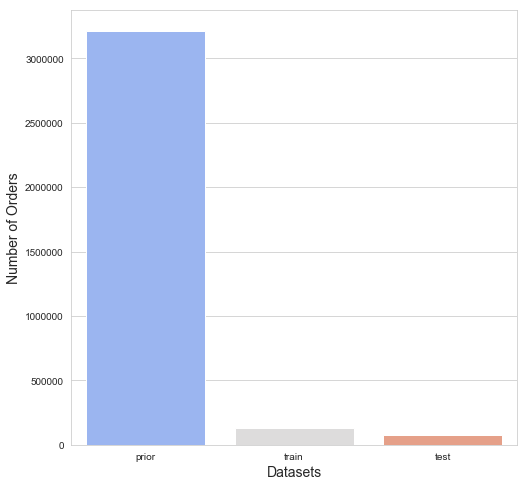

In [11]:
datasets = orders_data.eval_set.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(datasets.index, datasets.values, palette='coolwarm')
plt.ylabel('Number of Orders', fontsize=14)
plt.xlabel('Datasets', fontsize=14)
plt.show()

In [12]:
orders_data.groupby("eval_set")["order_id"].unique().apply(len)

eval_set
prior    3214874
test       75000
train     131209
Name: order_id, dtype: int64

In [13]:
print("Number of orders in order_products_prior: ", len(op_prior.order_id.unique()))
print("Number of orders in order_products_train: ", len(op_train.order_id.unique()))

Number of orders in order_products_prior:  3214874
Number of orders in order_products_train:  131209


In [14]:
orders_data[orders_data.eval_set == "train"].head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
49,2196797,5,train,5,0,11,6.0
74,525192,7,train,21,2,11,6.0
78,880375,8,train,4,1,14,10.0


In [15]:
orders_data[orders_data.eval_set == "test"].head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [16]:
op_train[op_train.order_id == 1187899]

,order_id,product_id,add_to_cart_order,reordered
484420,1187899,196,1,1
484421,1187899,25133,2,1
484422,1187899,38928,3,1
484423,1187899,26405,4,1
484424,1187899,39657,5,1
484425,1187899,10258,6,1
484426,1187899,13032,7,1
484427,1187899,26088,8,1
484428,1187899,27845,9,0
484429,1187899,49235,10,1


<h4>Summary of What We Have Learned So Far</h4>
The dataset has been broken up into different chunks that will need to be merged and parsed in order to create our features. The orders.csv contains user order data with 1 row per order and an eval_set designation of either prior, train or test. These designations signify which order_products file will contain the actual order data. We can see that from the total 206,209 orders we identified in the dataset, the final purchase made by 131,209 users has been labeled as train. This suggests that these final orders are going to be used to train our model. Cross referencing the order_id with the prior and train csv files confirms that the number of orders labeled as "prior" and "train" align exactly with the number of unique order_id's in the corresponding files.

Now that we have an idea of what we're looking at, we should examine most frequently reordered products using the data from order_products__prior.csv (Serigne, 2017). We should be able to develop some ideas about which features will be predictive from this analysis.

<h4>Most Commonly Ordered Products</h4>

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


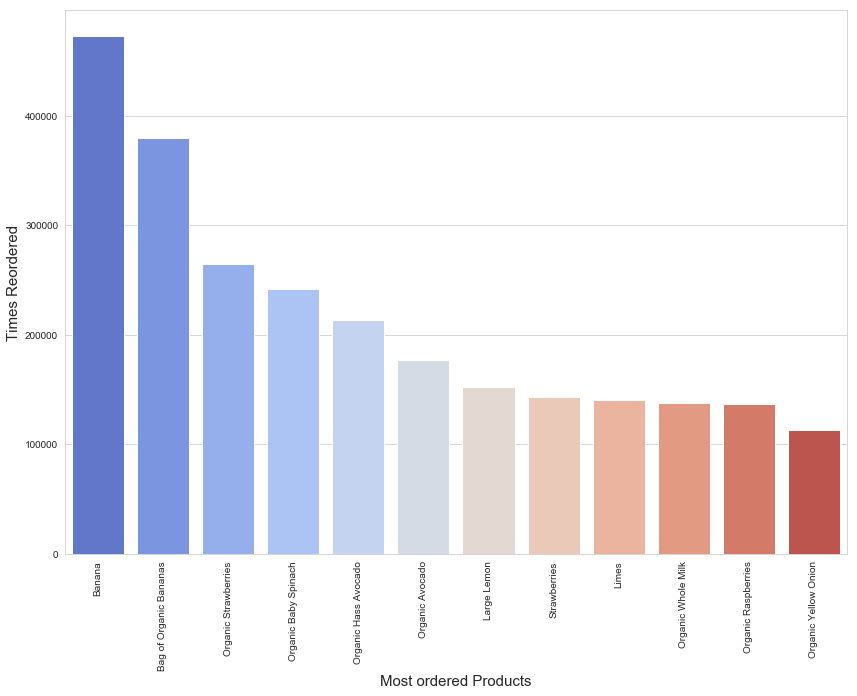

In [17]:
top_items = op_prior.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()
top_items = pd.merge(top_items, products_data[['product_id', 'product_name']], how='left', on=['product_id'])
top_items = top_items.sort_values(by='Total_reorders', ascending=False)[:12]
top_items = top_items.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(14, 10))
plt.xticks(rotation='vertical')
sns.barplot(top_items.index, top_items.values, palette='coolwarm')
plt.ylabel('Times Reordered', fontsize=15)
plt.xlabel('Most ordered Products', fontsize=15)
plt.show()

This shows us that fruits and vegetables dominate the top most ordered products list. What are the most frequently re-ordered products? The table below shows the products that are most likely to be reordered, sorted by the probability. (Serigne, 2017)

In [18]:
top_reorders = op_prior.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
top_reorders['reorder_probability'] = top_reorders['reorder_sum'] / top_reorders['reorder_total']
top_reorders = pd.merge(top_reorders, products_data[['product_id', 'product_name']], how='left', on=['product_id'])
top_reorders = top_reorders[top_reorders.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:15]
top_reorders

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,81,87,0.931034,Serenity Ultimate Extrema Overnight Pads
27734,27740,93,101,0.920792,Chocolate Love Bar
35598,35604,90,100,0.900000,Maca Buttercups
38243,38251,99,111,0.891892,Benchbreak Chardonnay
36794,36801,85,96,0.885417,Organic Blueberry B Mega
10232,10236,113,129,0.875969,Fragrance Free Clay with Natural Odor Eliminat...
20594,20598,98,112,0.875000,Thousand Island Salad Snax
35490,35496,389,451,0.862528,Real2 Alkalized Water 500 ml
5454,5457,75,87,0.862069,Classic Carbonated Natural Mineral Water
9288,9292,2517,2921,0.861691,Half And Half Ultra Pasteurized


The table of products that have the highest probability of being reordered is dominated by beverages, especially milk, but also water and a specific brand of wine. Just because, let's look at how many unique users ordered that specific wine.

In [19]:
# search for product id in product_prior, pull out order_id, find number of unique user_id's associated with those 
# order_id's in orders.csv
#wine_orders = op_prior.product_id == 38251
#wine_orders.head()
op_prior[op_prior.product_id == 38251].head()
#orders_data[orders_data.order_id == 29321]
#orders_data[orders_data.order_id == 52633]
#orders_data[orders_data.order_id == 79415]
#orders_data[orders_data.order_id == 111974]

,order_id,product_id,add_to_cart_order,reordered
278555,29321,38251,3,1
497682,52633,38251,1,1
750249,79415,38251,1,1
1060757,111974,38251,1,1
1468264,154796,38251,2,1


Text(0.5,0,'Number of users')

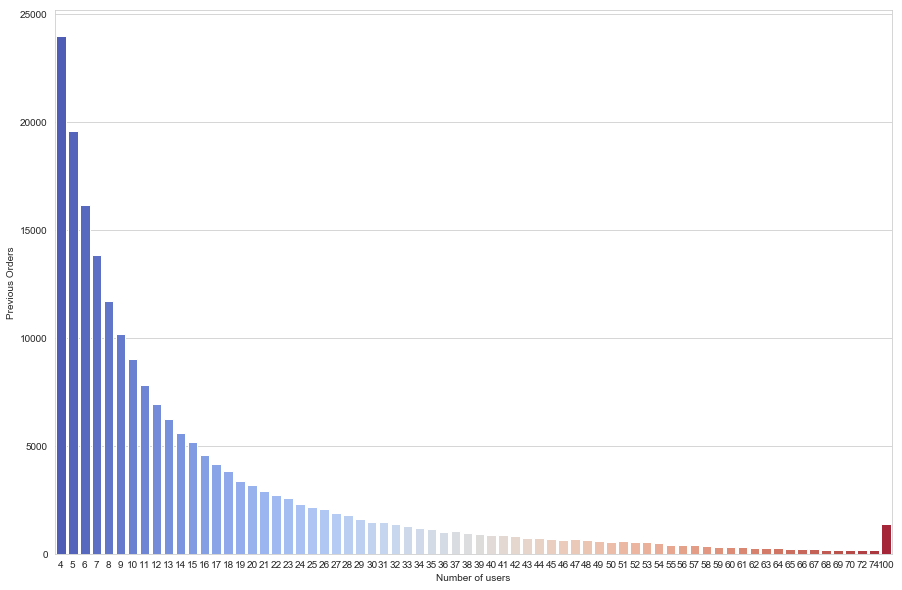

In [20]:
#(Pan, 2017)
order_length_cnt = orders_data.groupby("user_id")["order_number"].aggregate(max).value_counts()
cut_off = 70
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(order_length_cnt.index[:cut_off], order_length_cnt.values[:cut_off], palette='coolwarm')
plt.ylabel('Previous Orders')
plt.xlabel('Number of users')

As expected, most users have placed 4 prior orders, which is the minimum number of orders in this dataset. As the number of prior orders increases, the number of users drops off and levels out.

<h4>Feature Creation</h4>

After examining the data, it's time to start thinking about what features we can build. We merged order_products_prior.csv with products.csv and orders.csv to get the customer and order data in one place. To make a prediction on whether or not a product will be in the customer's next order, we need to come up with a few features to train the model on. We will use the labels from the train data which contains the last order from the customer.To do that, the dataframe must consist of a row for each product a customer ever ordered and a column specifying whehter that product will be in the next order or not.
That means we need to convert all of the order data and transform the dataframe into feature based information. 
The features we are considering are:
Total number of orders of a particular product - times purchased
Total proportion of orders containing a given product
Average number of items in an order
Average position in cart
Number of times the item was reordered
Max number of orders between orders containing that product
Day of the week and how often a given product was ordered on that day or at that time
Number of days since prior order
The longest that a customer has gone without buying product



Let's merge the order_products__prior.csv with products.csv and then merge the result with orders.csv.

In [21]:
prior_products = pd.merge(op_prior,products_data, on="product_id", how="inner")
prior_products.drop('product_name', inplace=True, axis=1)
print("prior_products: ", prior_products.shape)
prior_products.head()

prior_products:  (32434489, 6)


,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id
0,2,33120,1,1,86,16
1,26,33120,5,0,86,16
2,120,33120,13,0,86,16
3,327,33120,5,1,86,16
4,390,33120,28,1,86,16


In [22]:
prior_products_orders = pd.merge(prior_products,orders_data, on="order_id", how="inner")[['eval_set', 'user_id', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'aisle_id', 'department_id', 'add_to_cart_order', 'reordered']]
print("prior_products_orders: ", prior_products_orders.shape)
prior_products_orders.head()

prior_products_orders:  (32434489, 12)


,eval_set,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,aisle_id,department_id,add_to_cart_order,reordered
0,prior,202279,2,3,5,9,8.0,33120,86,16,1,1
1,prior,202279,2,3,5,9,8.0,28985,83,4,2,1
2,prior,202279,2,3,5,9,8.0,9327,104,13,3,0
3,prior,202279,2,3,5,9,8.0,45918,19,13,4,1
4,prior,202279,2,3,5,9,8.0,30035,17,13,5,0


We now have a table with one line per product per order. Now we will be creating some new columns to work with.

In [23]:
prior_products_orders['user_product_id'] = prior_products_orders.product_id + prior_products_orders.user_id.astype(np.int64) * 100000
prior_products_orders['reorder_total'] = prior_products_orders.groupby(['user_product_id'])['reordered'].transform('sum')
prior_products_orders['no_of_orders'] = prior_products_orders.groupby(['user_id'])['order_number'].transform('max')
prior_products_orders['order_ratio'] = (prior_products_orders['reorder_total'] + 1) / prior_products_orders['no_of_orders']
print(prior_products_orders.shape)
prior_products_orders.head()

(32434489, 16)


,eval_set,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,aisle_id,department_id,add_to_cart_order,reordered,user_product_id,reorder_total,no_of_orders,order_ratio
0,prior,202279,2,3,5,9,8.0,33120,86,16,1,1,20227933120,4,8,0.625
1,prior,202279,2,3,5,9,8.0,28985,83,4,2,1,20227928985,4,8,0.625
2,prior,202279,2,3,5,9,8.0,9327,104,13,3,0,20227909327,0,8,0.125
3,prior,202279,2,3,5,9,8.0,45918,19,13,4,1,20227945918,4,8,0.625
4,prior,202279,2,3,5,9,8.0,30035,17,13,5,0,20227930035,2,8,0.375


<b>user_product_id</b> concatenates user_id and product_id so that we have a uniqe identifier for each product ever purchased by a user.

<b>reorder_total</b> is the number of times a product was reordered by an individual user. If a user orders bananas 5 times, reorder_total will be 4.

<b>no_of_orders</b> is is the number of times a user placed an order.

<b>order_ratio</b> is the ratio of how many orders included a specific product out of the total number of orders a user placed.
We will be using these new columns to build our features.

In [24]:
print('Total number of unique orders: ',len(prior_products_orders.order_id.unique()))
prior_products_orders.loc[prior_products_orders['user_id'] == 112108].sort_values(['user_id', 'order_number', 'product_id', 'department_id', 'aisle_id'])


Total number of unique orders:  3214874


,eval_set,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,aisle_id,department_id,add_to_cart_order,reordered,user_product_id,reorder_total,no_of_orders,order_ratio
30058910,prior,112108,1427983,1,1,14,NaN,11109,108,16,6,0,11210811109,1,3,0.666667
30058907,prior,112108,1427983,1,1,14,NaN,14947,115,7,7,0,11210814947,2,3,1.000000
30058906,prior,112108,1427983,1,1,14,NaN,22035,21,16,5,0,11210822035,1,3,0.666667
30058911,prior,112108,1427983,1,1,14,NaN,30881,95,15,3,0,11210830881,1,3,0.666667
30058909,prior,112108,1427983,1,1,14,NaN,42001,95,15,1,0,11210842001,0,3,0.333333
30058912,prior,112108,1427983,1,1,14,NaN,43633,95,15,2,0,11210843633,1,3,0.666667
30058908,prior,112108,1427983,1,1,14,NaN,44359,83,4,8,0,11210844359,1,3,0.666667
30058913,prior,112108,1427983,1,1,14,NaN,49302,120,16,4,0,11210849302,1,3,0.666667
19101416,prior,112108,2541372,2,1,10,7.0,2067,3,19,7,0,11210802067,0,3,0.333333
19101421,prior,112108,2541372,2,1,10,7.0,5707,3,19,8,0,11210805707,1,3,0.666667


Above we have all of the order data for user 112108 with a single line for each item.

Now we will begin creating our labels. We will merge the order data with the order_products__train.csv.

In [25]:
labels = pd.merge(op_train,orders_data, on="order_id", how="inner")[['eval_set', 'user_id', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'reordered']]
print("labels: ", labels.shape)
print("Number of customers: ", len(labels.user_id.unique()))
print("Number of orders: ", len(labels.order_id.unique()))
print("This is the last order of 131,209 customers, which will be used to create the Y label and train the model.")
labels.head()


labels:  (1384617, 10)
Number of customers:  131209
Number of orders:  131209
This is the last order of 131,209 customers, which will be used to create the Y label and train the model.


,eval_set,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,train,112108,1,4,4,10,9.0,49302,1,1
1,train,112108,1,4,4,10,9.0,11109,2,1
2,train,112108,1,4,4,10,9.0,10246,3,0
3,train,112108,1,4,4,10,9.0,49683,4,0
4,train,112108,1,4,4,10,9.0,43633,5,1


Now we're creating a table that we can merge with our initial dataset. <b>in_last_order</b> is 1 for all items in the table because we will use this to indicate which products were in the last order.

In [26]:
labels['user_product_id'] = labels.product_id + labels.user_id.astype(np.int64) * 100000
labels['in_last_order'] = 1
labels.drop(['eval_set', 'user_id', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'reordered'], inplace=True, axis=1)
labels.head()

,user_product_id,in_last_order
0,11210849302,1
1,11210811109,1
2,11210810246,1
3,11210849683,1
4,11210843633,1


Now we will create a simplified training_data table without any order related data. This table only cares about customer, product and special features.

In [40]:
training_data = prior_products_orders.drop(['eval_set','order_id','order_number','order_dow','order_hour_of_day','days_since_prior_order','add_to_cart_order','reordered'], axis=1)
print(training_data.shape)
training_data.head()

(32434489, 8)


,user_id,product_id,aisle_id,department_id,user_product_id,reorder_total,no_of_orders,order_ratio
0,202279,33120,86,16,20227933120,4,8,0.6
1,202279,28985,83,4,20227928985,4,8,0.6
2,202279,9327,104,13,20227909327,0,8,0.1
3,202279,45918,19,13,20227945918,4,8,0.6
4,202279,30035,17,13,20227930035,2,8,0.4


Now we need to drop duplicates.

In [41]:
training_data.drop_duplicates(subset=['user_product_id'], inplace=True)
print(training_data.shape)
training_data.head()

(13307953, 8)


,user_id,product_id,aisle_id,department_id,user_product_id,reorder_total,no_of_orders,order_ratio
0,202279,33120,86,16,20227933120,4,8,0.6
1,202279,28985,83,4,20227928985,4,8,0.6
2,202279,9327,104,13,20227909327,0,8,0.1
3,202279,45918,19,13,20227945918,4,8,0.6
4,202279,30035,17,13,20227930035,2,8,0.4


In [42]:
print('Number of unique products ordered by individual users: ',len(training_data.user_product_id.unique()))

Number of unique products ordered by individual users:  13307953


Now we're merging the training data table with the labels and zero-filling anything that wasn't in the labels dataframe. We now have an <b>in_last_order</b> column indicating whether or not a product was in the last order.

In [43]:
training_data = pd.merge(training_data, labels, how='left', on='user_product_id')
training_data['in_last_order'].fillna(0, inplace=True)
training_data['in_last_order'] = training_data['in_last_order'].astype('int32')
training_data.head()

,user_id,product_id,aisle_id,department_id,user_product_id,reorder_total,no_of_orders,order_ratio,in_last_order
0,202279,33120,86,16,20227933120,4,8,0.6,1
1,202279,28985,83,4,20227928985,4,8,0.6,0
2,202279,9327,104,13,20227909327,0,8,0.1,0
3,202279,45918,19,13,20227945918,4,8,0.6,0
4,202279,30035,17,13,20227930035,2,8,0.4,0


In [44]:
#sanity check to make sure we didn't add any rows.
print(training_data.shape)

(13307953, 9)


<h4>Model Building</h4>

We have our data prepared and ready for our model. 
Now we are separating our data into X and Y to feed to our model. X is our feature space and Y is the labels.

In [45]:
X_train = training_data.drop(['in_last_order'], axis=1)
y_train = training_data['in_last_order']

In [46]:
pd.set_option('display.width', 100)
pd.set_option('precision', 1)
print(training_data.describe())

       user_id  product_id  aisle_id  department_id  user_product_id  reorder_total  no_of_orders  \
count  1.3e+07     1.3e+07   1.3e+07        1.3e+07          1.3e+07        1.3e+07       1.3e+07   
mean   1.0e+05     2.6e+04   7.1e+01        1.0e+01          1.0e+10        1.4e+00       2.5e+01   
std    5.9e+04     1.4e+04   3.8e+01        6.2e+00          5.9e+09        3.6e+00       2.2e+01   
min    1.0e+00     1.0e+00   1.0e+00        1.0e+00          1.0e+05        0.0e+00       3.0e+00   
25%    5.2e+04     1.3e+04   3.2e+01        4.0e+00          5.2e+09        0.0e+00       9.0e+00   
50%    1.0e+05     2.6e+04   8.1e+01        1.1e+01          1.0e+10        0.0e+00       1.8e+01   
75%    1.5e+05     3.8e+04   1.1e+02        1.6e+01          1.5e+10        1.0e+00       3.5e+01   
max    2.1e+05     5.0e+04   1.3e+02        2.1e+01          2.1e+10        9.8e+01       9.9e+01   

       order_ratio  in_last_order  
count      1.3e+07        1.3e+07  
mean       1.5e-01

In [47]:
plt.figure()
corMat = training_data.corr(method='pearson')
print(corMat)

                 user_id  product_id  aisle_id  department_id  user_product_id  reorder_total  \
user_id          1.0e+00    -2.4e-04   2.3e-05        3.3e-04          1.0e+00       -7.1e-04   
product_id      -2.4e-04     1.0e+00   3.7e-03       -2.6e-02         -2.4e-04        3.0e-03   
aisle_id         2.3e-05     3.7e-03   1.0e+00        2.7e-02          2.3e-05        3.2e-03   
department_id    3.3e-04    -2.6e-02   2.7e-02        1.0e+00          3.3e-04       -3.3e-02   
user_product_id  1.0e+00    -2.4e-04   2.3e-05        3.3e-04          1.0e+00       -7.1e-04   
reorder_total   -7.1e-04     3.0e-03   3.2e-03       -3.3e-02         -7.1e-04        1.0e+00   
no_of_orders    -3.8e-03    -2.7e-03  -2.8e-03        2.0e-02         -3.8e-03        2.4e-01   
order_ratio      4.1e-04     4.7e-03   6.0e-03       -4.9e-02          4.1e-04        4.7e-01   
in_last_order   -4.2e-04     2.1e-03   1.8e-03       -2.6e-02         -4.2e-04        1.9e-01   

                 no_of_orders

<Figure size 432x288 with 0 Axes>

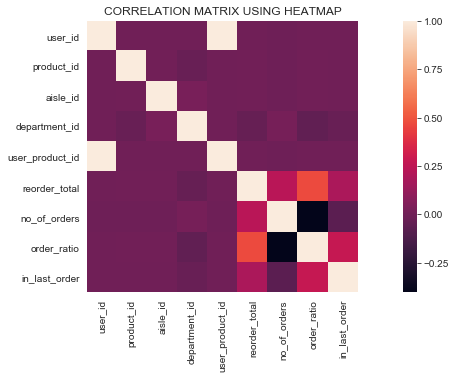

In [48]:
plt.figure(figsize = (16,5))
sns.heatmap(corMat, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("CORRELATION MATRIX USING HEATMAP")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a180d75c0>,
      dtype=object)

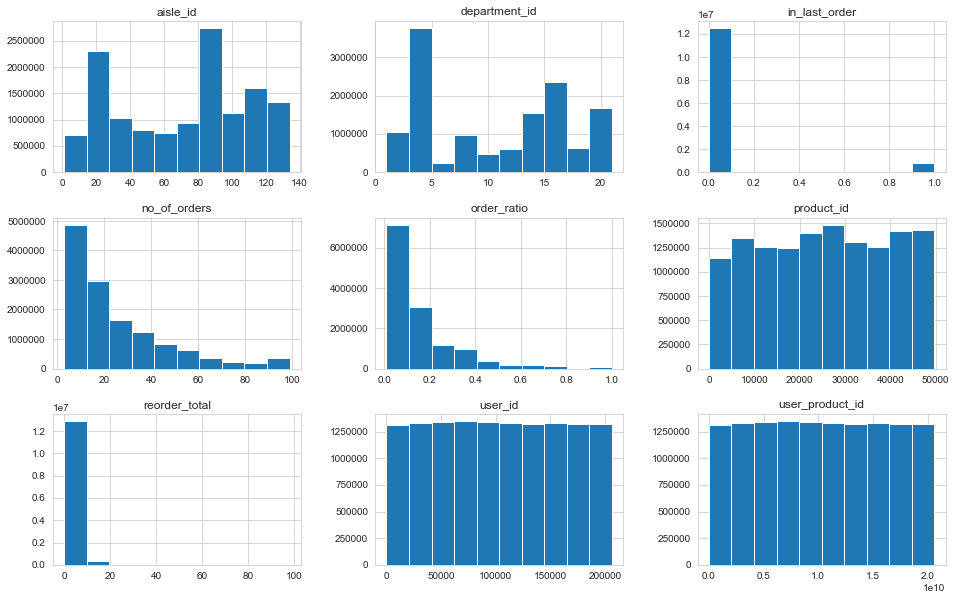

In [49]:
training_data.hist(figsize=(16, 10))

In [ ]:
scatter_matrix(training_data_test, figsize=(20,20))
plt.show()

In [58]:
#Create the data set for testing: X_test
X_test = orders_data.loc[orders_data['eval_set'] == "test"]
print("X_test: ", X_test.shape)
print("Unique customers: ", len(X_test.user_id.unique()))
print("Unique orders: ", len(X_test.order_id.unique()))
X_test.head()

X_test:  (75000, 7)
Unique customers:  75000
Unique orders:  75000


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [59]:
X_test = pd.merge(X_test, training_data, on="user_id", how="left")
print("X_test: ", X_test.shape)
print("Unique customers: ", len(X_test.user_id.unique()))
print("Unique orders: ", len(X_test.order_id.unique()))
X_test.head()

X_test:  (4833292, 15)
Unique customers:  75000
Unique orders:  75000


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,aisle_id,department_id,user_product_id,reorder_total,no_of_orders,order_ratio,in_last_order
0,2774568,3,test,13,5,15,11.0,1819,88,13,301819,2,12,0.2,0
1,2774568,3,test,13,5,15,11.0,21903,123,4,321903,7,12,0.7,0
2,2774568,3,test,13,5,15,11.0,14992,83,4,314992,1,12,0.2,0
3,2774568,3,test,13,5,15,11.0,16797,24,4,316797,2,12,0.2,0
4,2774568,3,test,13,5,15,11.0,9387,24,4,309387,4,12,0.4,0


In [60]:
print(len(X_test[X_test["order_id"].isnull()]))

0


In [61]:
submission = X_test[['order_id','user_id','product_id','user_product_id',]]
print("Unique orders: ", len(X_test.order_id.unique()))

Unique orders:  75000


In [62]:
X_test = X_test[['user_id','product_id','aisle_id','department_id','user_product_id','reorder_total','no_of_orders','order_ratio']]
print("X_test: ", X_test.shape)
print("Unique customers: ", len(X_test.user_id.unique()))
X_test.head()

X_test:  (4833292, 8)
Unique customers:  75000


,user_id,product_id,aisle_id,department_id,user_product_id,reorder_total,no_of_orders,order_ratio
0,3,1819,88,13,301819,2,12,0.2
1,3,21903,123,4,321903,7,12,0.7
2,3,14992,83,4,314992,1,12,0.2
3,3,16797,24,4,316797,2,12,0.2
4,3,9387,24,4,309387,4,12,0.4


In [63]:
print("X_train: ", X_train.shape)
X_train.head()

X_train:  (13307953, 8)


,user_id,product_id,aisle_id,department_id,user_product_id,reorder_total,no_of_orders,order_ratio
0,202279,33120,86,16,20227933120,4,8,0.6
1,202279,28985,83,4,20227928985,4,8,0.6
2,202279,9327,104,13,20227909327,0,8,0.1
3,202279,45918,19,13,20227945918,4,8,0.6
4,202279,30035,17,13,20227930035,2,8,0.4


<h3>Training using Bagging Classifier</h3>

In [64]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(bootstrap=True)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

y_pred.head()

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [68]:
submission['y_pred'] = y_pred
submission.head()

,order_id,user_id,product_id,user_product_id,y_pred
0,2774568,3,1819,301819,0
1,2774568,3,21903,321903,0
2,2774568,3,14992,314992,0
3,2774568,3,16797,316797,0
4,2774568,3,9387,309387,0


In [69]:
sample = pd.read_csv('sample_submission.csv')
sample.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


In [71]:
sample.dtypes

order_id     int64
products    object
dtype: object

In [98]:
submission_dict = {}
for index, row in submission.iterrows():
    if row['y_pred'] == 1:
        if row['order_id'] in submission_dict and submission_dict[row['order_id']] != None:
            submission_dict[row['order_id']].append(row['product_id'])
        else:
            submission_dict[row['order_id']] = [row['product_id']]
    else:
        if row['order_id'] not in submission_dict:
            submission_dict[row['order_id']] = None

In [99]:
print(len(submission_dict))
for order, products in submission_dict.items():
    if products is not None:
        submission_dict[order] = ' '.join(map(str, submission_dict[order]))

75000


In [100]:
import csv
with open('submission.csv', 'w') as f:
    for key in submission_dict.keys():
        f.write("%s,%s\n"%(key,submission_dict[key]))

<h3>Training Using Ada Boost</h3>

In [ ]:
# Boosting method, three boosting algorithms
# First Ada boost
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier()
ada_clf.fit(X_train, y_train)

y_pred_ada = ada_clf.predict(X_test)
y_pred_ada.head()

<h3>Results (Plots, tables, etc.)</h3>
.
.
.

<h3>Conclusions</h3>
.
.
.

<h3>References</h3>

Chen, Edwin (2017, September 19). Instacart Market Basket Analysis, Winner's Interview: 2nd place, Kazuki Onodera [Blog Post]. Retrieved from http://blog.kaggle.com/2017/09/21/instacart-market-basket-analysis-winners-interview-2nd-place-kazuki-onodera/

Onodera, Kazuki (2017). Instacart Market Basket Analysis 2nd place solution [GitHub Repository]. Retrieved from https://github.com/KazukiOnodera/Instacart

Pan, Yao (2017, September 8). Data Exploratory for Instacart Market Basket Analysis [Jupyter Notebook]. Retrieved from https://github.com/panyao/instacart-solution/blob/master/exploration/Data%20Exploratory%20for%20Instacart%20Market%20Basket%20Analysis.ipynb

Serigne (2017, July 5). Instacart Simple Data Exploration [Kaggle Notebook]. Retrieved from https://www.kaggle.com/serigne/instacart-simple-data-exploration

Sh1ng (2017, August 7). Baseline 0.4029970 [Kaggle Discussion]. Retreieved from https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/37697

Spachtholz, Philipp (2017, June 29). Exploratory Analysis - Instacart [Kaggle Report]. Retrieved from https://www.kaggle.com/philippsp/exploratory-analysis-instacart/notebook

Stanley, Jeremy (2017, May 3). 3 Million Instacart Orders, Open Sourced [
Sudalairaj, Kumar (2017, June 1). Simple Exploration Notebook - Instacart [Kaggle Report]. Retrieved from https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart/notebook

Tkm2261 (2017, August 16). My 15th Solution Features (mainly using BigQuery) [Kaggle Notebook]. Retrieved from https://www.kaggle.com/tkm2261/my-15th-solution-features-mainly-using-bigquery

Vasquez, Sean (2017, August 21). Instacart Market Basket Analysis [GitHub Repository]. Retrieved from https://github.com/sjvasquez/instacart-basket-prediction


<h3>Appendix (Code, other relevant documents, etc.)</h3>
.
.
.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
order_products_train_df = pd.read_csv("../input/order_products__train.csv")
order_products_prior_df = pd.read_csv("../input/order_products__prior.csv")
orders_df = pd.read_csv("../input/orders.csv")
products_df = pd.read_csv("../input/products.csv")
aisles_df = pd.read_csv("../input/aisles.csv")
departments_df = pd.read_csv("../input/departments.csv")

In [ ]:
orders_df.head()

In [ ]:
order_products_prior_df.head()

In [ ]:
order_products_train_df.head()

In [ ]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(10,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of orders', fontsize=14)
plt.xlabel('Data type', fontsize=14)
plt.title('Prior vs. Train vs. Test', fontsize=18)
plt.xticks(rotation='horizontal')
plt.show()

In [ ]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

In [ ]:
import pandas as pd

aisles_data = pd.read_csv('aisles.csv')
aisles_data.head()

In [ ]:
departments_data = pd.read_csv('departments.csv')
departments_data.head()

In [ ]:
orders_data = pd.read_csv('orders.csv')
orders_data.head()

In [ ]:
products_data = pd.read_csv('products.csv')
products_data.head()

In [ ]:
sample = pd.read_csv('sample_submission.csv')
sample.head()

In [ ]:
op_prior = pd.read_csv('order_products__prior.csv')
op_prior.head()
print(op_prior[(op_prior.order_id == 17)])

In [ ]:
op_train = pd.read_csv('order_products__train.csv')
op_train.head()